In [1]:
# num_features = описательные статистики
# cat_features = энтропия, число уникальных значений, наличие чисел, логарифм вероятности наименьшего, логарифм вероятности наибольшего
# name_features = энтропия распределения по символам, количество слов (описательные статистики), количество символов в 1-3 словах (описательные статистики), наличие заглавных букв
# text_features = энтропия распределения по символам, описательные статистики от средней длины в символах / словах, описательные статистики числа кириллицы, латиницы, спецсимволов
# date_features = делим на 3 компоненты, добавляем небольшой шум, строим по ним описательные статистики


In [813]:
np.random.choice(5)

4

In [123]:
%config Completer.use_jedi = False

In [655]:
from scipy import stats
from scipy.stats import entropy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [174]:
np.set_printoptions(suppress=True)

In [857]:
def is_number_repl_isdigit(s):
    """ Returns True if string is a number. """
    if isinstance(s, str):
        return s.replace('.','',1).isdigit()
    else:
        return True

    
# ДОБАВИТЬ ПОИСК ДУБЛИКАТОВ
def get_num_feature_stats(vals: pd.Series):
    is_digit_values = vals.apply(is_number_repl_isdigit)
    
    vals_digit = vals[is_digit_values].astype('float')
    vals_not_digit = vals[~is_digit_values]
    
    is_nan = vals_digit.isna()
    vals_digit_not_nan = vals_digit[~is_nan]
    
    if not vals_digit_not_nan.empty:
        quantiles = np.quantile(vals_digit_not_nan, [0.25, 0.5, 0.75, 0.95])
        descr = stats.describe(vals_digit_not_nan)
        
        return quantiles.tolist() + [
            descr.nobs, 
            descr.minmax[0], 
            descr.minmax[1], 
            descr.mean, 
            np.sqrt(descr.variance), 
            descr.skewness, 
            descr.kurtosis,
            is_digit_values.sum() / vals.shape[0],
            is_nan.sum() / vals.shape[0]
        ]
    else:
        return [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, (~is_digit_values).sum() / vals.shape[0], is_nan.sum() / vals.shape[0]]

In [858]:
def get_cat_feature_stats(vals: pd.Series):
    vals_counts = vals.value_counts()
    vals_probas = vals_counts / vals_counts.sum()
    entr = entropy(vals_probas.values)    
    vals_probas_log = np.log(vals_probas)
    descr = stats.describe(vals_probas_log)
    
    # добавить log odds
    # добавить count - количество уникальных атрибутов
    
    quantiles = np.quantile(vals_probas_log, [0.25, 0.5, 0.75, 0.95])
    
    return quantiles.tolist() + [
        entr, 
        descr.nobs, 
        descr.minmax[0], 
        descr.minmax[1], 
    ]

In [859]:
get_num_feature_stats(pd.Series([0,'1','2',3,4,np.nan]))

[1.0,
 2.0,
 3.0,
 3.8,
 5,
 0.0,
 4.0,
 2.0,
 1.5811388300841898,
 0.0,
 -1.3,
 1.0,
 0.16666666666666666]

In [860]:
get_cat_feature_stats(pd.Series(['a', 'a', 'b', 'b', 'c', 23]))

[-1.791759469228055,
 -1.791759469228055,
 -1.4451858789480823,
 -1.0986122886681098,
 -1.0986122886681098,
 1.3296613488547582,
 0.6666666666666666,
 -1.791759469228055,
 -1.0986122886681098]

# Скачивание данных

In [861]:
import os
import json

In [862]:
FEATURE_CATEGORICAL = 'categorical'
FEATURE_NUMERIC = 'numeric'

metadata = json.load(open("./Datasets/Real/BankChurners/metadata.json", 'r'))

In [863]:
metadata.keys()

dict_keys(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'])

### Чистые данные

In [864]:
CLEAN_DATASET_DIR = './Datasets/Real/BankChurners/Clear'

features = {}
for fname in os.listdir(CLEAN_DATASET_DIR):
    if fname.endswith('.csv'):
        dataframe = pd.read_csv(f'{CLEAN_DATASET_DIR}/{fname}')
        
        for k, v in metadata.items():
            if k not in features:
                features[k] = []
            
            if v == FEATURE_CATEGORICAL:
                features[k].append(get_cat_feature_stats(dataframe[k]))
            elif v == FEATURE_NUMERIC:
                features[k].append(get_num_feature_stats(dataframe[k]))
                
features_clean = features

### Аномалии (Группированные)

In [865]:
DIRTY_DATASET_DIR = './Datasets/Real/BankChurners/DirtyGrouped'

dirty_datasets_grouped = {}
for fname in os.listdir(DIRTY_DATASET_DIR):
    if fname.endswith('.csv'):
        dirty_datasets_grouped[fname] = {}
        features = dirty_datasets_grouped[fname]
        dataframe = pd.read_csv(f'{DIRTY_DATASET_DIR}/{fname}')
        
        for k, v in metadata.items():
            if k not in features:
                features[k] = []
            
            if v == FEATURE_CATEGORICAL:
                features[k] = get_cat_feature_stats(dataframe[k])
            elif v == FEATURE_NUMERIC:
                features[k] = get_num_feature_stats(dataframe[k])

/Users/ppogorelov/VirtualEnv/v2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ppogorelov/VirtualEnv/v2/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [866]:
dirty_datasets_grouped.keys()

dict_keys(['beta.csv', 'alpha.csv'])

### Объединение данных (Группированные данные)

In [867]:
for dname, dvalue in dirty_datasets_grouped.items():
    for fname, fvalue in features_clean.items():
        dvalue[fname] = fvalue + [dvalue[fname]]

# Алгоритм поиска аномальных факторов

In [930]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import scipy.stats as ss

In [869]:
from pyod.models.iforest import IForest
import eif

In [911]:
forest = IsolationForest(n_estimators=100, random_state=42)
lof = LocalOutlierFactor(n_neighbors=15, novelty=True)

In [960]:
column_to_features = {k: np.array(v) for k, v in dirty_datasets_grouped['alpha.csv'].items()}

In [961]:
lof.score_samples(fvalue_trans)

array([  1.43265894,   1.43265857,   1.98906772,   1.4150856 ,
         2.93001893,   1.1586962 ,   1.17652846,   1.69601968,
         1.99720413,   1.8232184 ,   1.08595935,   1.4318592 ,
         1.28339418,   0.77554496,   1.11764854,   1.86049056,
         1.13396414,   0.30573843,   1.75961388,   1.43227791,
         1.27076288,   1.43749496,   1.43205695,   0.62383076,
         1.96760768,   1.69834709,   1.43183276,   1.50115401,
         1.09896765,   2.38971048, -44.08941299])

In [962]:
column_to_scores_forest = {}
column_to_scores_lof = {}

column_to_preds_forest = {}
column_to_scores_lof = {}

for fname, fvalue in column_to_features.items():
    forest = IsolationForest(n_estimators=100, random_state=42)
    #lof = LocalOutlierFactor(n_neighbors=15, novelty=True)
    lof = OneClassSVM(kernel='linear')
    scaler = StandardScaler()
    
    fvalue_trans = scaler.fit_transform(fvalue)
    
    forest.fit(fvalue_trans)
    lof.fit(fvalue_trans[:-1])
    
    column_to_scores_forest[fname] = forest.decision_function(fvalue_trans)
    #column_to_scores_lof[fname] = (-lof.negative_outlier_factor_).tolist() + -lof.score_samples([fvalue_trans[-1]])
    column_to_scores_lof[fname] = -lof.score_samples(fvalue_trans)
    
    expon_params_forest = ss.expon.fit(column_to_scores_forest[fname][:-1] - 1)
    expon_params_lof = ss.expon.fit(column_to_scores_lof[fname][:-1] - 1)
    
    column_to_preds_forest[fname] = ss.expon.cdf([column_to_scores_forest[fname][-1] - 1], *expon_params_forest)
    column_to_preds_lof[fname] = ss.expon.cdf([column_to_scores_lof[fname][-1] - 1], *expon_params_lof)
    
    #preds = -preds
    #preds[preds < 0] = 0

In [963]:
column_to_preds_lof

{'CLIENTNUM': array([0.90373705]),
 'Attrition_Flag': array([1.]),
 'Customer_Age': array([0.7212009]),
 'Gender': array([1.]),
 'Dependent_count': array([0.58707978]),
 'Education_Level': array([1.]),
 'Marital_Status': array([1.]),
 'Income_Category': array([0.65213083]),
 'Card_Category': array([0.72326455]),
 'Months_on_book': array([0.74988109]),
 'Total_Relationship_Count': array([0.77957524]),
 'Months_Inactive_12_mon': array([0.85052332]),
 'Contacts_Count_12_mon': array([0.]),
 'Credit_Limit': array([1.]),
 'Total_Revolving_Bal': array([1.]),
 'Avg_Open_To_Buy': array([0.46907718]),
 'Total_Amt_Chng_Q4_Q1': array([0.726767]),
 'Total_Trans_Amt': array([1.]),
 'Total_Ct_Chng_Q4_Q1': array([0.70320378]),
 'Avg_Utilization_Ratio': array([0.66582985])}

/Users/ppogorelov/VirtualEnv/v2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


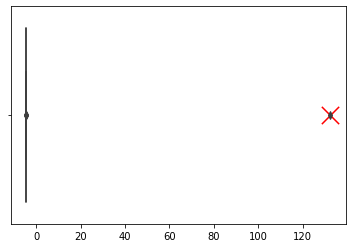

In [964]:
ax = sns.boxplot(column_to_scores_lof['Attrition_Flag'])
ax.scatter(column_to_scores_lof['Attrition_Flag'][-1], 0, color='r', marker='x', s=300)

<AxesSubplot:>

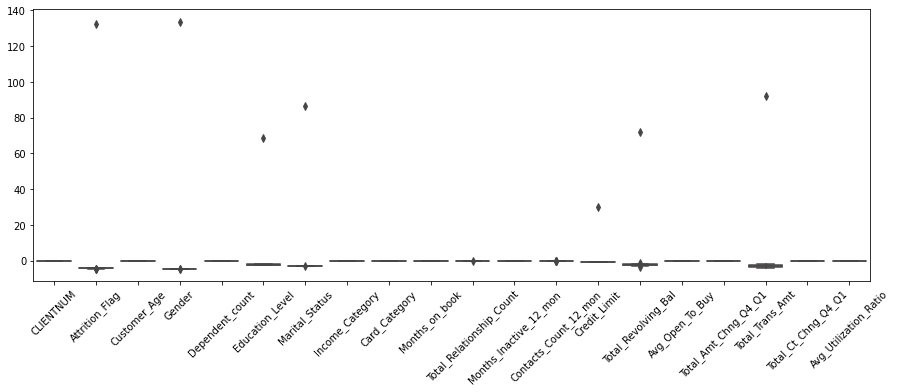

In [965]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
sns.boxplot(data=pd.DataFrame(column_to_scores_lof))#.drop(['Attrition_Flag', 'Gender'], axis=1))

<AxesSubplot:>

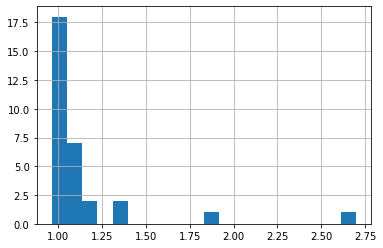

In [887]:
pd.Series(column_to_preds_lof['Credit_Limit']).hist(bins=20)

In [878]:
#column_to_features['Dependent_count'][21]

In [879]:
StandardScaler().fit_transform(column_to_features['Credit_Limit'])

array([[ 0.02026013, -0.73975002,  0.01112345,  0.76507407,  0.18257419,
        -0.        ,  0.        , -0.5860795 , -0.49027079,  0.82333783,
         0.85318321,  0.        , -0.18257419],
       [-0.6897254 , -0.46322322, -0.96728299,  0.76507407,  0.18257419,
        -0.        ,  0.        , -0.44850964,  0.32186445,  0.80937744,
         0.42258353,  0.        , -0.18257419],
       [ 1.54945975,  0.1365673 , -0.06235371,  0.76507407,  0.18257419,
        -0.        ,  0.        , -0.01397873,  0.10570392,  0.523313  ,
         0.34967277,  0.        , -0.18257419],
       [ 0.98283668,  1.25435872,  0.42620497, -0.77326526,  0.18257419,
        -0.        ,  0.        ,  0.33698033, -0.53069869, -0.54198022,
        -0.23449666,  0.        , -0.18257419],
       [ 0.56640285, -0.11659104,  0.21350792,  0.76507407,  0.18257419,
        -0.        ,  0.        ,  0.10811307,  0.25858142, -0.08665889,
        -0.15142642,  0.        , -0.18257419],
       [-0.07531484,  1.791833